In [3]:
%time
import itertools
import pandas as pd
import os
import numpy as np
import csv
import tensorflow as tf
import keras as ks
from keras.preprocessing.text import one_hot # encodes a sequence into list of integers (for embedding)
from keras.preprocessing.text import hashing_trick # same as one hot, but do not need vocabulary
from keras.preprocessing.sequence import pad_sequences  # pads lists to same size
from keras.layers import Dense, Flatten, Reshape        # different neural network layers 
from keras import regularizers, Model, Input            # additiontal nn variables
from keras.models import load_model

import pickle            # writting and reading efficiently from files
from sklearn.preprocessing import LabelBinarizer     # convert strings to output labels
from sklearn.model_selection import train_test_split # split into training and testing data

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3d plotting
plt.style.use('ilya_jupyter')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 11 µs


In [5]:
# limit symbols to common a-z and other word symbols such as !#
min_symbol = 32                 # !
max_symbol = 122                # z
vocabulary_size = int(max_symbol - min_symbol + 2)
max_tag_length = 15

# path definitions
data_folder = "./ilya_data"
model_tagPredictor_save = "./ilya_model/model_tagPredictor"
global_param = "./ilya_model/global_param"
model_autoencoder_save = "./ilya_model/model_autoencoder"

In [6]:
def word_to_nums(w):
    """convert words to number format"""
    return [ord(c) for c in w]

def convert_string_to_numeric(string_to_convert, max_tag_length=15):
    """
    __ Parameters __
    [str] string_to_convert: string to represent as an integer list

    __ Description __
    converts a string to it's numeric list representation. handles a-z and !#$...etc
    it is padded to have a length of "max_tag_length" trimming any exess or padding empty spaces with 0

    __ Return __
    [int-list] numeric_representation: of string
    """

    # 1 - cast char to integer
    numeric_representation = np.array([ord(char) for char in string_to_convert])

    # 2 - to being enumerating from zero, remove the offest for the first allowed character
    offset = 32
    numeric_representation = numeric_representation - offset

    # 2 - pad to "max_tag_length" - empty spaces are filled with 0's - excess characters are trimmed
    numeric_representation = pad_sequences([numeric_representation], max_tag_length, truncating='post', padding='post')[0]
    
    return numeric_representation

def predict(tag, model, vocabulary_size, max_tag_length, output_labels):
    """
    __ Parameters __
    [str] word: word to predict
    [keras] model: model to use to predict word
    [int] vocabulary_size: vocabularly size used to encode the tags during training

    __ Description __
    returns prediction array for the given tag

    __ Return __
    [int] output_numeric, [str] output_string, [arr] probabilities
    """
    
    # 1 - encode the tag as an integer
    tag_integer = convert_string_to_numeric(tag)
        
    # 3 - run prediction
    raw_prediction = model.predict(tag_integer)
    
    # 4 - create array of the form [0, 1, 0 ,0] to indicate highest value
    output_numeric = np.argmax(raw_prediction[0])
    output_string = output_labels[output_numeric]
    
    return output_numeric, output_string, raw_prediction[0]

def save_parameters(lb, vocabulary_size, max_input_length,
                    parameter_file="./ilya_model/global_param"):
    """
    __ Parameters __
    [LabelBinarizer] lb: sklearn.preprocessing.LabelBinarizer that was used to create unique binaries from list of strings (output)
    [int] vocabulary_size: vocabularly size used to encode input during training (input)
    [int] max_input_length: length of the input (input)
    [str] parameter_file: location to save data

    __ Description __
    stores all the parameters used by the model
    """

    # 1 - extract all the binary labels
    output_map = lb.classes_

    # 2 - dump to file
    with open("./ilya_model/global_param", "wb") as fout:
        pickle.dump({"Output_Map": output_map,
                     "Vocabulary_Size": vocabulary_size,
                     "Max_Input_Length": max_input_length},
                    fout)

def load_parameters(parameter_file="./ilya_model/global_param"):
    """
    __ Parameters __
    [str] parameter_file: file to load from
    
    __ Description __
    loads parameters to work with model

    __ Return __
    [list-str] output: ordered list of string output ["description", "label"]
    """
    with open("./ilya_model/global_param", "rb") as fin:
        data = pickle.load(fin)

    vocabulary_size = data["Vocabulary_Size"]
    max_input_length = data["Max_Input_Length"]
    output_labels = data["Output_Map"]
    
    return vocabulary_size, max_input_length, output_labels

In [ ]:
#✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ Formatting the data ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘ ✘
# - SKIP TO "Load prepared data ← avoids running code" if datasets are ready

%time
data_file = "CPU.csv"
tags = []                       # some kind of information about device
tags_numeric = []               # tag represetnation in number form
field = []                   # "Description", "Brand" or "Part Number"

# 1 - open data file, which has the columns [tag, field, irlv, irlv, irlv]
with open("%s/%s" %(data_folder, data_file), 'rnd') as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        
        # a - get number of columns based on the number in first row
        if (i==0):
            n_columns = len(row)

        # b - read in colums
        temp_tags = row[0]
        temp_tag_numeric = np.array(word_to_nums(temp_tags))
        temp_field = row[1]
        temp_field_numeric = np.array(word_to_nums(temp_field))

        # c - skip over bad data
        if any(temp_tag_numeric < min_symbol) or any(temp_tag_numeric > max_symbol):
            continue
        if (any(np.array(word_to_nums(temp_field)) > max_symbol)
            or any( temp_field_numeric > max_symbol)):
            continue
        if n_columns != len(row):
            continue

        # d - store data
        tags.append(temp_tags)
        field.append(temp_field)
        tags_numeric.append(temp_tag_numeric)
        
# 2 - import some noise data
irr = np.load(os.path.join(data_folder, "irrelevant_text_training.npy"))

for w in irr:
    # a - convert to numeric format
    temp_tag_numeric = np.array(word_to_nums(w))

    # b - skip empty word and bad formatting
    if w=='':
        continue
    if any(temp_tag_numeric<min_symbol) or any(temp_tag_numeric>max_symbol):
        continue

    # c - add noise to fields
    tags.append(w)
    field.append('Irrelevant')
    tags_numeric.append(temp_tag_numeric)

# 3 - write all data to file for easy access
all_fields = list(set(field))   # {'Brand', 'Description', 'Part_number'}
data = {
    "tags": tags,               # all extracted tags
    "field": field,             # fields that the tags are under
    "tags_numeric": tags_numeric, # numeric representation
    "all_fields": all_fields # {'Brand', 'Description', 'Part_number'}
}
with open('ilya_dataML', 'wb') as fout:
    pickle.dump(data, fout)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Load prepared data ← avoids running code above
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [7]:
%time
# 1 - load in data avoiding running the above code
with open('./ilya_model/data_verbose', 'rb') as fin:
    data = pickle.load(fin)

# 2 - extract tags and fields
tags = data["tags"]
fields = data["field"]
all_fields = data["all_fields"]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


# Preparing numeric representation of dataset

In [8]:
%time 
# 1 - encode each tag as a list of integers of length "max_tag_length"
data_in = [convert_string_to_numeric(tag, max_tag_length) for tag in tags]

# 2 - build output array. taking a 1D array of string
# (e.g.['Brand', 'Part_number', 'Description', ..., 'Irrelevant')
# and converting it to a 0s and 1s matrix i.e. [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
data_out = np.array(fields)
lb = LabelBinarizer()
data_out = lb.fit_transform(data_out)

# 3 - save parameters
save_parameters(lb, vocabulary_size, max_tag_length)
np.save("./ilya_model/data_in.npy", data_in)
np.save("./ilya_model/data_out.npy", data_out)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


# Build neural network

In [9]:
%time
########################################
embedding_dim = 80            # dimension of the vector that each input is cast into
########################################
# 1 - declare size of input
dim_in = data_in.shape[1]    # each input tag will be a list of 15 numbers
dim_out = data_out.shape[1]  # each output will be an array of 4 values [0, 0, 0, 1]

# 2 - INPUT -> convert input sequences to embedded vectors → flatten 2D array [[s1w1, s1w2, ...], [s2w1, s2w2, ...], ...] → Normalize
inputs = ks.Input((dim_in,))
x = ks.layers.Embedding(vocabulary_size, embedding_dim, input_length=dim_in, name='embedding')(inputs)
x = ks.layers.Flatten()(x)
x = ks.layers.BatchNormalization()(x)

# 3 - 1st Hidden Layer (with l1 regularizer, penalising large weight values to avoid overfitting) → Activate
x = ks.layers.Dense(2*dim_in, kernel_regularizer=ks.regularizers.l1(0.05), name='first_dense')(x)
x = ks.layers.LeakyReLU(0.1)(x)

# 5 - 2nd Hidden Layer → Activate → Normalize → Go to output
x = ks.layers.Dense(2*dim_in, kernel_regularizer=ks.regularizers.l1(0.05), name='second_dense')(x)
x = ks.layers.LeakyReLU(0.1)(x)
x = ks.layers.BatchNormalization()(x)
x = ks.layers.Dense(dim_out, activation='sigmoid', name='output')(x)

# 6 - create model for training
model = ks.Model(inputs=inputs, outputs=x)
model.compile(loss=ks.losses.categorical_crossentropy, optimizer='adam')
print(model.summary())

model.save(model_tagPredictor_save)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


AttributeError: 'list' object has no attribute 'shape'

# Train NN and save logs for tensorboard

Train on 41939 samples, validate on 2208 samples
Epoch 1/25


 - 2s - loss: 41.3675 - val_loss: 17.4004


Epoch 2/25


 - 1s - loss: 8.7356 - val_loss: 5.2073


Epoch 3/25


 - 1s - loss: 4.1263 - val_loss: 3.4666


Epoch 4/25


 - 1s - loss: 2.8316 - val_loss: 2.3743


Epoch 5/25


 - 1s - loss: 1.9066 - val_loss: 1.5680


Epoch 6/25


 - 1s - loss: 1.2278 - val_loss: 0.9920


Epoch 7/25


 - 1s - loss: 0.8072 - val_loss: 0.7004


Epoch 8/25


 - 1s - loss: 0.6098 - val_loss: 0.6016


Epoch 9/25


 - 1s - loss: 0.5438 - val_loss: 0.5391


Epoch 10/25


 - 1s - loss: 0.5144 - val_loss: 0.4955


Epoch 11/25


 - 1s - loss: 0.4816 - val_loss: 0.4721


Epoch 12/25


 - 1s - loss: 0.4613 - val_loss: 0.4583


Epoch 13/25


 - 1s - loss: 0.4487 - val_loss: 0.4426


Epoch 14/25


 - 1s - loss: 0.4331 - val_loss: 0.4302


Epoch 15/25


 - 1s - loss: 0.4255 - val_loss: 0.4207


Epoch 16/25


 - 1s - loss: 0.4180 - val_loss: 0.4138


Epoch 17/25


 - 1s - loss: 0.4094 - val_loss: 0.4084


Epoch 18/25


 - 1s - loss: 0.4038 - val_loss: 0.4054


Epoch 19/25


 - 1s - loss: 0.3995 - val_loss: 0.4046


Epoch 20/25


 - 1s - loss: 0.3955 - val_loss: 0.3983


Epoch 21/25


 - 1s - loss: 0.3927 - val_loss: 0.4047


Epoch 22/25


 - 1s - loss: 0.3893 - val_loss: 0.3863


Epoch 23/25


 - 1s - loss: 0.3865 - val_loss: 0.3958


Epoch 24/25


 - 1s - loss: 0.3795 - val_loss: 0.3875


Epoch 25/25


 - 1s - loss: 0.3782 - val_loss: 0.3821


AttributeError: 'History' object has no attribute 'history_log'

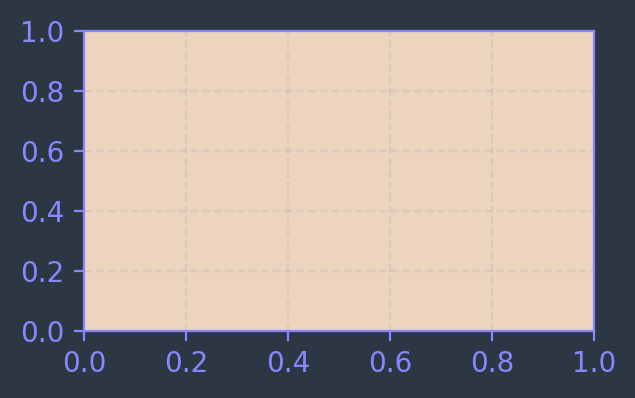

AttributeError: 'History' object has no attribute 'history_log'

In [19]:
########################################
training_name = "./ilya_model/tag_predictor_14thJune"
epochs = 25
########################################
# callbacks = [ks.callbacks.TensorBoard(embeddings_freq=10, embeddings_layer_names='embedding',
# embeddings_data=testing_in[:100, :])]
# 1 - Prepare training and testing datasets: Randomise the word inputs,  Select 90% for training, and 10% for testing
(in_train, in_test, out_train, out_test) = train_test_split(data_in, data_out, test_size = 0.1, random_state=42, shuffle=True)

# 2 - load the compiled model and begin training
model = ks.models.load_model(model_tagPredictor_save)
history_log = model.fit(in_train, out_train, verbose=2, epochs=epochs,
          batch_size=1000,validation_split=0.05)#, callbacks=callbacks)  # starts training
            
# 3 - save the weights
model.save(training_name)

# 4 plot training history_log
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(history_log.history_log["loss"])
ax.plot(history_log.history_log["val_loss"], color="C4")
ax.set_title("Training history_log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(["Train", "Valdiation"])

plt.show()

# Testing the model

In [12]:
########################################
n_tests = 1000
########################################
model = ks.models.load_model(training_name)
vocabulary_size, max_input_length, output_labels = load_parameters(global_param)

n_successes = 0
n_managable_errors = 0
i = 0
while i < n_tests:
    try:
        i += 1

        # 1 - extract random value in string format
        rnd = np.random.randint(0, len(tags))
        tag = tags[rnd]
        true_field = fields[rnd]
        
        # 2 - predict and compare
        field_numeric, field_string, raw_prediction = predict(tag, model, vocabulary_size, max_tag_length, output_labels)
        
        # 3 - run prediction
        if (field_string == true_field):
            n_successes += 1
        elif ({field_numeric, true_field} == {"Description", "Irrelevant"} or tag=="AMD"):
            n_managable_errors += 1
    except:
        pass

print(n_successes/n_tests*100, '%')
print('With managable errors: ', (n_managable_errors + n_successes)/n_tests*100, '%')

0.0 %
With managable errors:  0.0 %


In [29]:
# 1 - load model and parameters
model = ks.models.load_model(model_tagPredictor_save)
vocabulary_size, max_input_length, output_labels = load_parameters(global_param)

# 2 - upload training dataset
train_in = np.load("./ilya_model/data_in.npy")
train_out = np.load("./ilya_model/data_out.npy")

# 3 - train the model on batches of200 random values
training_size = 200
for i in range(0,20):
    train_indx = np.random.randint(0, len(train_in), size=training_size)
    model.fit(train_in[train_indx, :], train_out[train_indx, :],
              verbose=1, epochs=1, batch_size=32)

    # b - check quality
    correct = 0
    for i in range(0, 100):
        # a - take random tag and run prediction
        indx = np.random.randint(len(tags))
        tag = tags[indx]
        true_field = fields[indx]
        
        predict_numeric, predict_string, predict_raw = predict(
            tag, model, vocabulary_size, max_input_length, output_labels)

        if (predict_string == true_field):
            correct += 1

    print("\t\t\t\t\t%s" % (correct))

Epoch 1/1


 32/200 [===>..........................] - ETA: 5s - loss: 71.7651

200/200 [==============================] - 1s 5ms/step - loss: 67.7089


					37
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 60.5499

200/200 [==============================] - 0s 164us/step - loss: 56.6002


					40
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 50.1515

200/200 [==============================] - 0s 164us/step - loss: 46.6027


					49
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 40.9145

200/200 [==============================] - 0s 151us/step - loss: 37.7109


					62
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 32.6381

200/200 [==============================] - 0s 184us/step - loss: 30.0249


					66
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 25.5723

200/200 [==============================] - 0s 178us/step - loss: 23.3270


					75
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 19.9256

200/200 [==============================] - 0s 151us/step - loss: 18.0123


					78
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 15.2699

200/200 [==============================] - 0s 171us/step - loss: 13.7080


					76
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 11.5525

200/200 [==============================] - 0s 157us/step - loss: 10.4226


					76
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 8.8729

200/200 [==============================] - 0s 153us/step - loss: 8.3161


					70
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 7.5152

200/200 [==============================] - 0s 159us/step - loss: 7.2697


					70
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 6.8125

200/200 [==============================] - 0s 152us/step - loss: 6.6502


					73
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 6.3627

200/200 [==============================] - 0s 172us/step - loss: 6.1797


					74
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 5.9696

200/200 [==============================] - 0s 145us/step - loss: 5.7114


					67
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 5.4872

200/200 [==============================] - 0s 179us/step - loss: 5.2921


					74
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 5.1150

200/200 [==============================] - 0s 153us/step - loss: 4.9969


					76
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 4.8455

200/200 [==============================] - 0s 159us/step - loss: 4.8250


					74
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 4.8036

200/200 [==============================] - 0s 146us/step - loss: 4.6494


					77
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 4.5891

200/200 [==============================] - 0s 144us/step - loss: 4.4287


					85
Epoch 1/1
 32/200 [===>..........................] - ETA: 0s - loss: 4.2614

200/200 [==============================] - 0s 177us/step - loss: 4.2848


					80


# Playing with weights

In [ ]:
model = ks.models.load_model(model_tagPredictor_save)
model.layers[-4].get_weights()[0]

# Autoencoder - make sure "data_in" is loaded from above

## Use the trained "tag_model" to embed the tags into a (15x80) Dense vectors

In [8]:
# 1 - create a model that takes in tags and outputs their embedded vectors
#   - effecitvely this is the first layer of the "tag_predictor"
model_embed = Model(tag_model.inputs, tag_model.get_layer("embedding").output)

# 2 - run model on input tags, to turn each character into an embedded vector (?, 15) → (?, 15, 80) 
tags_embeded = model_embed.predict(data_in)

NameError: name 'tag_model' is not defined

## Pass the embeded tags to the autoencoder

In [131]:
########################################
encoding_funnel_dimension = 3
########################################
dim_in_1 = tags_embeded.shape[1]
dim_in_2 = tags_embeded.shape[2]

# 1 - input layer (?, 15, 80) → flatten to (?, 1200)
input_LAYER = Input((dim_in_1, dim_in_2), name="input_15x80")
flattened_LAYER = Flatten(name="flattend_15x80")(input_LAYER)

# 2 - middle "funnel" or encoding
encoding_LAYER = Dense(encoding_funnel_dimension, activation='relu', name="encoding",
                    activity_regularizer=regularizers.l1(10e-5))(flattened_LAYER)

# 3 - decode the funneled layer → reshape
decoding_LAYER = Dense(dim_in_1 * dim_in_2, activation='sigmoid',
                       name="decoding")(encoding_LAYER)
unflattened_LAYER = Reshape((dim_in_1, dim_in_2), name="reshaped_15x80")(decoding_LAYER)

# 4 - compile model
model_autoencoder = Model(input_LAYER, unflattened_LAYER)
model_autoencoder.compile(optimizer='adam', loss='mse')
print(model_autoencoder.summary())
model_autoencoder.save(model_autoencoder_save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15x80 (InputLayer)     (None, 15, 80)            0         
_________________________________________________________________
flattend_15x80 (Flatten)     (None, 1200)              0         
_________________________________________________________________
encoding (Dense)             (None, 3)                 3603      
_________________________________________________________________
decoding (Dense)             (None, 1200)              4800      
_________________________________________________________________
reshaped_15x80 (Reshape)     (None, 15, 80)            0         
Total params: 8,403
Trainable params: 8,403
Non-trainable params: 0
_________________________________________________________________
None


## Train autoencoder

In [7]:
########################################
training_name = "./ilya_model/model_autoencoder_14thJune"
epochs = 25
########################################
# 1 - load the compiled model and begin training
model = ks.models.load_model(model_autoencoder_save)
history_log = model.fit(tags_embeded, tags_embeded, verbose=1, epochs=epochs,
          batch_size=1000, validation_split=0.05)
            
# 3 - save the weights
model.save(training_name)

# 4 plot training history_log
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(history_log.history["loss"])
ax.plot(history_log.history["val_loss"], color="C4")
ax.set_title("Training history_log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(["Train", "Valdiation"])

plt.show()

Instructions for updating:
Colocations handled automatically by placer.


NameError: name 'tags_embeded' is not defined

In [6]:
viz_input_LAYER = model_autoencoder.get_layer("input_15x80").input
viz_output_LAYER = model_autoencoder.get_layer("encoding").output
vizualization_model = Model(viz_input_LAYER, viz_output_LAYER)

# 2 - run vizualisation on some of the tags
indx = np.random.randint(len(tags_embeded), size=400)
tags_encoded = vizualization_model.predict(tags_embeded[indx])
tag_fields = np.argmax(data_out[indx], axis=1) # extract the field that each tag belongs to

NameError: name 'model_autoencoder' is not defined

In [1]:
# %matplotlib qt
colors = ['navy', 'turquoise', 'darkorange']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colours = ['navy', 'turquoise', 'darkorange', 'red']

    
for colour, i, label in zip(colours, [0, 1, 2, 3], output_labels):
    ax.scatter(tags_encoded[tag_fields==i, 0],
               tags_encoded[tag_fields==i, 1],
               tags_encoded[tag_fields==i, 2],
               color=colour,
               label=label)
plt.show()
# tags_encoded.shape[]

NameError: name 'plt' is not defined

In [ ]:
# 1 - take embedding layer of the "tag_predictor model"
# the TRAINDE model will have the fitted weights that groups characters by context
tag_model = load_model(training_name)
embedding_LAYER = tag_model.get_layer("embedding")
# 92 characters, each with an 80-dimensional vector
embedding_LAYER.get_weights()[0].shape